# Logistic regression with tensorflow



## 1. Create Datset

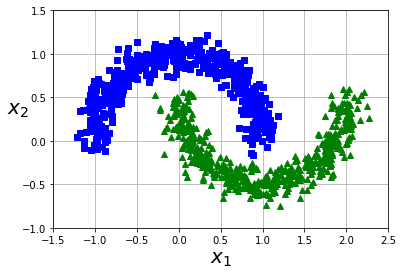

In [81]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
%matplotlib inline

def plot_dataset(X, y, axes=None):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    if axes is not None:
        plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
    
X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)
    
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

## 2. Prepare data

In [82]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test=  train_test_split(X,y,random_state=42, test_size=0.2)

scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

# add bias term since we want to use a linear model with intercerpt
X_train_scaled_with_bias=np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled] 
X_test_scaled_with_bias=np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled] 


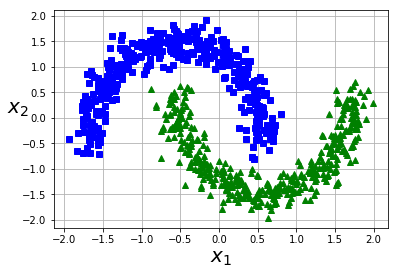

In [83]:
plot_dataset(X_train_scaled, y_train.squeeze())

## 3. Model

## 3.1 Simple version 




In [84]:
import tensorflow as tf

class LogisticRegression(object):
    
    def __init__(self, input_tensor, target_tensor):
        
        # input and output
        self.input=input_tensor
        self.target=target_tensor
    
        # model
        self.weights = tf.Variable(tf.random_uniform([3, 1], -1.0, 1.0, seed=42), name="theta")

        #self.weights=tf.Variable(tf.random.truncated_normal(shape=(int(input_tensor.shape[1]),1)),name="weights") 
        logits=tf.matmul(self.input,self.weights, name="linear")
        self.prediction=1/(1+tf.math.exp(-logits))

        # loss function to optimize
        self.loss=tf.losses.log_loss(self.target,self.prediction)
            #-tf.reduce_mean(tf.multiply(self.target, tf.math.log(self.prediction))
            #                      +tf.multiply(1-self.target, tf.math.log(1-self.prediction)))

        # define learning
        self.training_operation= tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(self.loss)

   
    def train(self,feed_dict):
        session=tf.get_default_session()
        session.run(self.training_operation, feed_dict)
        
    
    def get_loss(self,feed_dict):
        session=tf.get_default_session()
        return session.run(self.loss, feed_dict)
    
    def get_weights(self):
        session=tf.get_default_session()
        return session.run(self.weights)
    

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


We use the log loss function:

$J(\boldsymbol{\theta}) = -\dfrac{1}{m} \sum\limits_{i=1}^{m}{\left[ y^{(i)} \log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) \log\left(1 - \hat{p}^{(i)}\right)\right]}$


In [85]:
# training

tf.set_random_seed(42)
np.random.seed(42)

def get_random_batch(X,y, batchsize):
    indices=np.random.randint(0,X.shape[0],batchsize)
    return X[indices],y[indices]

reset_graph()

# define model
num_features=3
input=tf.placeholder(tf.float32, shape=(None,num_features),name="input")
target=tf.placeholder(tf.float32, shape=(None,1),name="target")
model= LogisticRegression(input, target)

batch_size=50
num_batches=int(X_train_scaled_with_bias.shape[0]/batch_size)


num_epoches=1001
with tf.Session() as sess:

    tf.global_variables_initializer().run()

    for e in range(num_epoches+1):
        for batch in range(num_batches):
            print
            X,y=get_random_batch(X_train_scaled_with_bias,y_train.reshape(-1,1),batch_size)
            model.train(feed_dict={input:X,target:y})

        if e %100==0:
            #output some training statistics
            value, op=tf.metrics.precision(labels=y_test, predictions=model.prediction>0.5) # precision metric only works on binary values
            tf.local_variables_initializer().run()
            precision=sess.run(op,feed_dict={input:X_test_scaled_with_bias,target:y_test.reshape(-1,1)})
            loss= model.get_loss(feed_dict={input:X_test_scaled_with_bias,target:y_test.reshape(-1,1)})
            print("Epoch %i, Error: %s, Precision: %s" % (e, loss,precision))
            prediction=sess.run(model.prediction,feed_dict={input:X_test_scaled_with_bias,target:y_test.reshape(-1,1)})   

    print("Weights:\n%s " % model.get_weights())
    
    # store prediction
    prediction=sess.run(model.prediction,feed_dict={input:X_test_scaled_with_bias,target:y_test.reshape(-1,1)})   


Epoch 0, Error: 0.7754189, Precision: 0.3968254
Epoch 100, Error: 0.27535388, Precision: 0.8613861
Epoch 200, Error: 0.25826958, Precision: 0.8640777
Epoch 300, Error: 0.25252938, Precision: 0.86538464
Epoch 400, Error: 0.24995095, Precision: 0.86538464
Epoch 500, Error: 0.24857768, Precision: 0.86538464
Epoch 600, Error: 0.24757442, Precision: 0.8557692
Epoch 700, Error: 0.24732864, Precision: 0.8490566
Epoch 800, Error: 0.24701972, Precision: 0.8490566
Epoch 900, Error: 0.24698688, Precision: 0.8490566
Epoch 1000, Error: 0.24679518, Precision: 0.8490566
Weights:
[[-0.00810336]
 [ 1.0736136 ]
 [-2.853737  ]] 


(200,)
0.8490566037735849


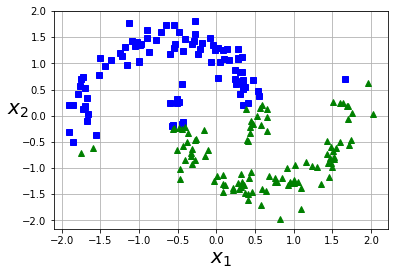

In [86]:
#visualize model
from sklearn.metrics import precision_score
pred=prediction.squeeze().copy()
print(pred.shape)
pred[pred>0.5]=1
pred[pred<=0.5]=0

print(precision_score(y_test,pred))

plot_dataset(X_test_scaled, pred)


Comment: Learning rate and num_epoches are not tuned, I stopped after finding a fast config that gives the same result as the optimal solution

In [40]:
# compare to sklearn 

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_score, log_loss

for ri in [num_epoches]:
    log_reg = SGDClassifier(loss='log',penalty=None, max_iter=ri, 
                            tol=0.00001, learning_rate='constant',eta0=0.001,shuffle=True,verbose=0)
    log_reg.fit(X_train_scaled, y_train)

    print("Log Loss: %s" % log_loss(y_pred=log_reg.predict_proba(X_train_scaled),y_true=y_train,normalize=True))
    print("Precision: %s" % precision_score(log_reg.predict(X_train_scaled),y_train))


    print("Weights: \n%s" % np.r_[log_reg.intercept_.reshape(-1, 1), log_reg.coef_.T])
    
#Precision: 0.8373493975903614

  #  Error: 0.31809413, Precision: 0.83625734
#[[ 0.18071988]
# [ 0.507316  ]
# [-1.7718898 ]] 
diff=log_reg.predict_proba(X_train_scaled)[:,1]-prediction.squeeze()
diff.mean()



Log Loss: 0.25808320156518755
Precision: 0.872093023255814
Weights: 
[[ 0.12219409]
 [ 1.04571325]
 [-2.7312587 ]]


ValueError: operands could not be broadcast together with shapes (670,) (330,) 

In [ ]:
log_reg

In [289]:
X_train_scaled

array([[ 1.30757366, -0.51663916],
       [ 1.35662731,  0.11315764],
       [-0.43257594,  1.74432112],
       [ 0.64582544,  0.8750939 ],
       [-0.1539692 , -1.17263151],
       [ 0.40351692,  1.0387441 ],
       [-2.12267578,  0.79229074],
       [ 1.48591713, -0.20724154],
       [-0.37991416,  1.17831977],
       [ 1.99991128, -0.21654259],
       [-1.49096873,  0.76412073],
       [-0.51095704,  0.42352862],
       [-1.57202978,  0.51741789],
       [-0.01229676,  0.17627621],
       [ 1.48573186, -0.75292446],
       [ 0.95334688, -1.06286772],
       [-1.83427511, -0.65143845],
       [ 2.05884646, -0.37970561],
       [ 0.45032709, -1.98452331],
       [ 2.25357343, -0.45568925],
       [-1.7036416 , -0.31801214],
       [ 0.75303024,  0.0312216 ],
       [ 0.11332371,  0.61739147],
       [-0.74016323,  0.79398405],
       [ 1.42927635, -0.43144841],
       [-1.12861201,  0.62755176],
       [-0.58970818,  1.09066971],
       [-1.18662759,  0.83153336],
       [-1.37513781,

## 3.2 Enhanced version

In [ ]:
# 1. make the graph reusable

def linear_regression(input_tensor, target_tensor, scope):
    with tf.variable_scope(scope):
         
        # model
        weights=tf.Variable(tf.random.truncated_normal(shape=(int(input_tensor.shape[1]),1)),name="weights") 
        prediction=tf.matmul(self.input,self.weights, name="prediction")

        # loss function to optimize
        self.error=tf.reduce_mean(tf.square(self.prediction-self.target))

        # define learning
        self.training_operation= tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(self.error)
        